#### import the things

In [2]:
import os
import nltk
import pandas as pd
import re
import string
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import numpy as np

In [5]:
wn = nltk.WordNetLemmatizer()
pd.set_option('display.max_colwidth', 100)
idx = pd.IndexSlice

In [6]:
from src.data import data_sorting_tools as dst
%load_ext autoreload
%autoreload 2

In [7]:
def remove_things(list_to_clean, to_remove):
    new_list = [thing for thing in list_to_clean if thing not in to_remove]
    return new_list

In [8]:
stopwords = nltk.corpus.stopwords.words('english')
custom_stopwords = ['amp']
stopwords = stopwords + custom_stopwords

In [9]:
def clean_tweet(tweet):
    """code adpated from LinkedIn Learning class NLP with Python for Machine Learning Essential Training by Derek Jedamski"""    
    tweet = "".join([word.lower() for word in tweet if word not in string.punctuation])
    tokens = re.split('\W+', tweet)
    tweet = [wn.lemmatize(word) for word in tokens if word not in stopwords]   
    return tweet

#### load the data and process the text

In [10]:
df = pd.read_pickle("../data/compiled/full_dataset_cleaned.pkl")

In [11]:
df.head()

,,quote_count,reply_count,retweet_count,favorite_count,user_followers_count,user_verified,full_text,media_count,media_types
tid,uid,,,,,,,,,
1333476068192366593,2152363202,0,2,3,16,6070,False,"Teen pregnancy is high, HIV infection rate is growing fastest among teens, and teens are experim...",0,none
1364161232270487553,1331332400836726785,0,0,0,0,62,False,Even though it was a charity. Stevens thought that speaking to DHSS rather than those suffering...,0,none
1364161201291153414,150301804,0,0,0,0,1044,False,SCORA\nStanding Committee on Sexual &amp; Reproductive Health and Rights including HIV&amp;AIDS\...,0,none
1364161184505737217,1317091162159747075,0,0,0,0,15,False,"many females are HIV+, we wish you well, blessings, we can't heal you totally, but providing rel...",0,none
1363439109948149760,1353391442408792066,0,0,2,24,184,False,@TheRustler83 Yep. Imagine if the government were demanding HIV tests weekly in every high school.,0,none


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7662 entries, (1333476068192366593, 2152363202) to (1363949692288004103, 308788980)
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   quote_count           7662 non-null   Int64  
 1   reply_count           7662 non-null   Int64  
 2   retweet_count         7662 non-null   Int64  
 3   favorite_count        7662 non-null   Int64  
 4   user_followers_count  7662 non-null   Int64  
 5   user_verified         7662 non-null   boolean
 6   full_text             7662 non-null   object 
 7   media_count           7662 non-null   Int64  
 8   media_types           7662 non-null   string 
dtypes: Int64(6), boolean(1), object(1), string(1)
memory usage: 1.1+ MB


In [152]:
tdf = df.loc[idx[:,],['full_text']]
tdf = tdf.reset_index().drop(columns='uid')

In [153]:
tdf['clean'] = tdf['full_text'].apply(lambda x: clean_tweet(x))

In [154]:
tdf['hashtags'] = tdf['full_text'].apply(lambda x: re.findall(r"#(\w+)", x.lower().strip()))
tdf['hashtags_count'] = tdf['hashtags'].apply(lambda x: len(x))
tdf['mentions'] = tdf['full_text'].apply(lambda x: re.findall(r"@(\w+)", x.lower().strip()))
tdf['mentions_count'] = tdf['mentions'].apply(lambda x: len(x))

tdf['full_word_count'] = tdf['full_text'].apply(lambda x: len(x.split(' ')))

In [170]:
new_tweets = {}
for row in tdf.index:
    text = tdf.at[row, 'clean']
    hashtags = tdf.at[row, 'hashtags']
    mentions = tdf.at[row, 'mentions']
    new_text = [word for word in text if word not in ' '.join(hashtags)]
    new_text = ' '.join([word for word in new_text if word not in ' '.join(mentions)])
    ind = tdf.at[row, 'tid']
    new_tweets[ind] = new_text

In [171]:
tdf = tdf.merge(pd.Series(new_tweets, name='clean_no_@#'), left_on='tid', right_index=True)

In [166]:
tdf['hashtags_ratio'] = tdf.apply(lambda x: np.round(x['hashtags_count'] / len(x['clean_no_@#']), 3), axis=1)
tdf['mentions_ratio'] = tdf.apply(lambda x: np.round(x['mentions_count'] / len(x['clean_no_@#']), 3), axis=1)

In [176]:
tdf.head()

,tid,full_text,clean,hashtags,hashtags_count,mentions,mentions_count,full_word_count,hashtags_ratio,mentions_ratio,clean_no_@#
0,1333476068192366593,"Teen pregnancy is high, HIV infection rate is growing fastest among teens, and teens are experim...","[teen, pregnancy, high, hiv, infection, rate, growing, fastest, among, teen, teen, experimenting...",[],0,[],0,22,0.000,0.000,teen pregnancy high hiv infection rate growing fastest among teen teen experimenting sex need srh
1,1364161232270487553,Even though it was a charity. Stevens thought that speaking to DHSS rather than those suffering...,"[even, though, charity, stevens, thought, speaking, dhss, rather, suffering, 1980, 1990, hiv, ha...","[hiv, haemophilia]",2,[bloodinquiry],1,25,0.167,0.083,even though charity stevens thought speaking dhss rather suffering 1980 1990 httpstcohzrl1mm0rx
2,1364161201291153414,SCORA\nStanding Committee on Sexual &amp; Reproductive Health and Rights including HIV&amp;AIDS\...,"[scora, standing, committee, sexual, reproductive, health, right, including, hivampaids, cimsa, ...",[],0,[],0,15,0.000,0.000,scora standing committee sexual reproductive health right including hivampaids cimsa empowering ...
3,1364161184505737217,"many females are HIV+, we wish you well, blessings, we can't heal you totally, but providing rel...","[many, female, hiv, wish, well, blessing, cant, heal, totally, providing, relief, medicine, salv...",[],0,[],0,33,0.000,0.000,many female hiv wish well blessing cant heal totally providing relief medicine salve specialty m...
4,1363439109948149760,@TheRustler83 Yep. Imagine if the government were demanding HIV tests weekly in every high school.,"[therustler83, yep, imagine, government, demanding, hiv, test, weekly, every, high, school]",[],0,[therustler83],1,15,0.000,0.100,yep imagine government demanding hiv test weekly every high school


#### try some data transformations

<AxesSubplot:xlabel='full_word_count', ylabel='Density'>

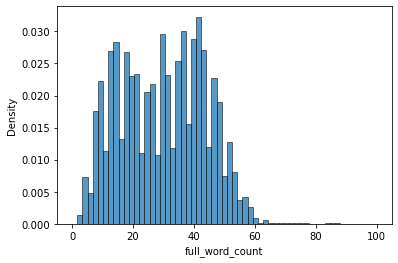

In [238]:
bins = np.linspace(0, 100, 60)
sns.histplot(tdf['full_word_count'], bins = bins, stat='density')

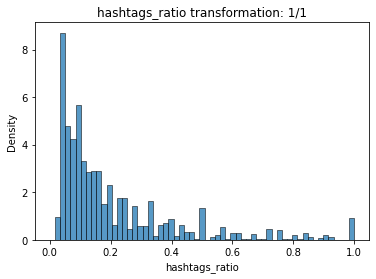

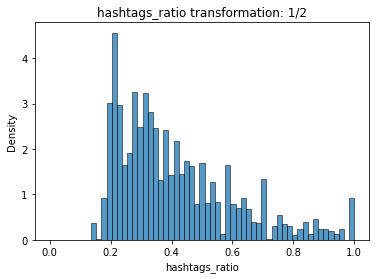

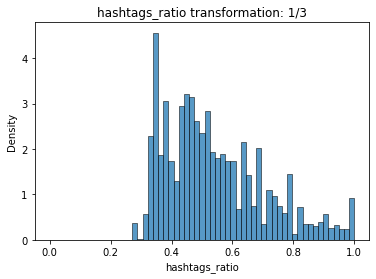

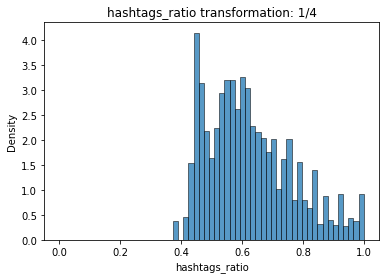

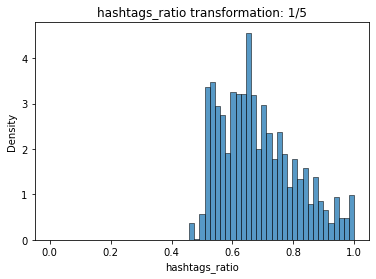

In [228]:
bins = np.linspace(0, 1, 60)
# plt.hist(tdf['hashtags_ratio'], bins)
# plt.show()

col = 'hashtags_ratio'

for i in [1,2,3,4,5]:
    sns.histplot(tdf[tdf[col] > 0][col]**(1/i), bins = bins, stat='density')
#     sns.histplot(tdf[col]**(1/i), bins = bins, stat='density')
#     plt.hist((tdf[col])**(1/i), bins=40, normalize =True)
    plt.title('{} transformation: 1/{}'.format(col, i))
    plt.show()

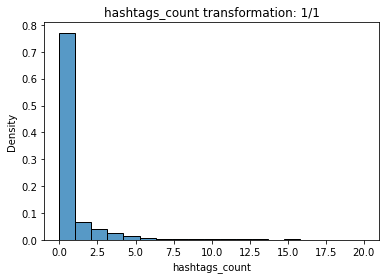

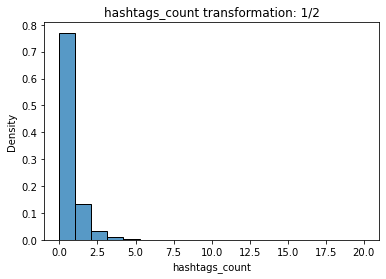

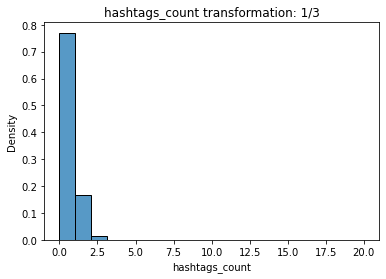

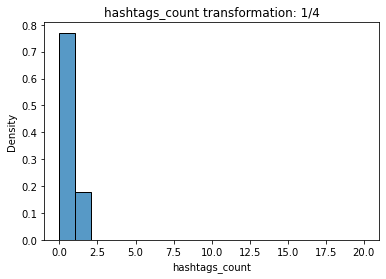

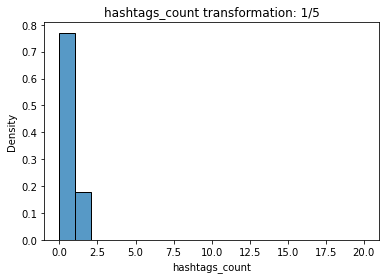

In [230]:
bins = np.linspace(0, 20, 20)
# plt.hist(tdf['hashtags_ratio'], bins)
# plt.show()

col = 'hashtags_count'

for i in [1,2,3,4,5]:
#     sns.histplot(tdf[tdf[col] > 0][col]**(1/i), bins = bins, stat='density')
    sns.histplot(tdf[col]**(1/i), bins = bins, stat='density')
#     plt.hist((tdf[col])**(1/i), bins=40, normalize =True)
    plt.title('{} transformation: 1/{}'.format(col, i))
    plt.show()

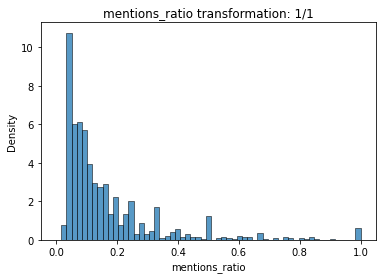

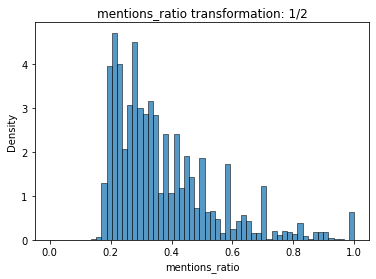

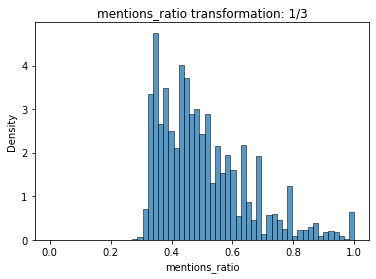

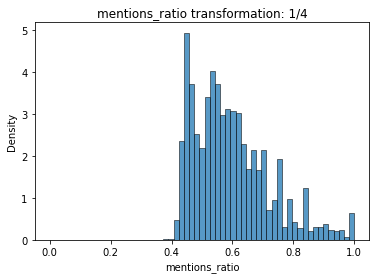

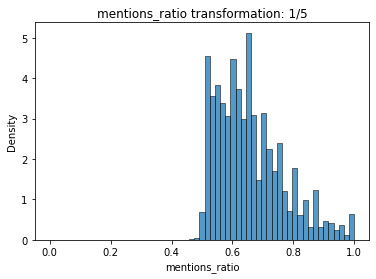

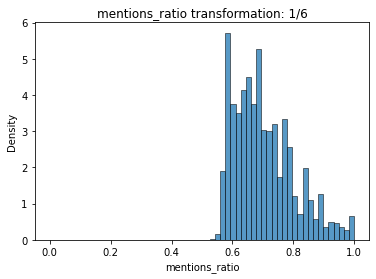

In [239]:
bins = np.linspace(0, 1, 60)
# plt.hist(tdf['mentions_ratio'], bins)
col = 'mentions_ratio'

for i in [1,2,3,4,5, 6]:
    sns.histplot(tdf[tdf[col] > 0][col]**(1/i), bins = bins, stat='density')
#     sns.histplot(tdf[col]**(1/i), bins = bins, stat='density')
#     plt.hist((tdf[col])**(1/i), bins=40, normalize =True)
    plt.title('{} transformation: 1/{}'.format(col, i))
    plt.show()

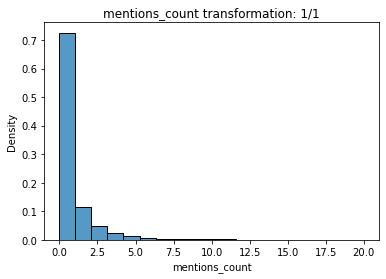

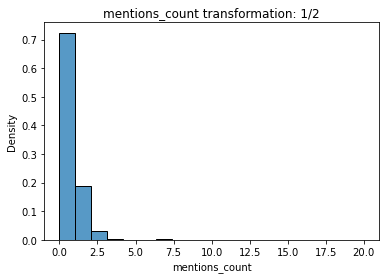

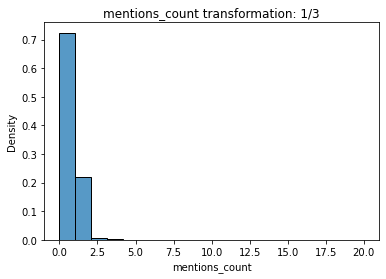

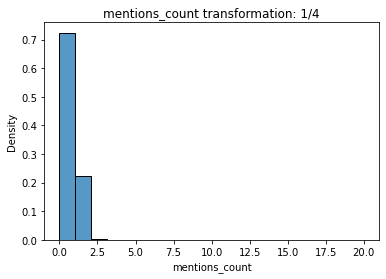

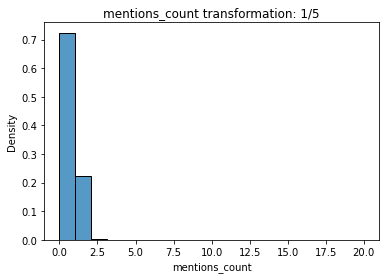

In [232]:
bins = np.linspace(0, 20, 20)
# plt.hist(tdf['mentions_count'], bins)
col = 'mentions_count'

for i in [1,2,3,4,5]:
#     sns.histplot(tdf[tdf[col] > 0][col]**(1/i), bins = bins, stat='density')
    sns.histplot(tdf[col]**(1/i), bins = bins, stat='density')
#     plt.hist((tdf[col])**(1/i), bins=40, normalize =True)
    plt.title('{} transformation: 1/{}'.format(col, i))
    plt.show()

In [240]:
df.columns

Index(['quote_count', 'reply_count', 'retweet_count', 'favorite_count',
       'user_followers_count', 'user_verified', 'full_text', 'media_count',
       'media_types'],
      dtype='object')

In [245]:
df['favorite_count'].values

<IntegerArray>
[16,  0,  0,  0, 24,  0,  0, 19,  0, 91,
 ...
  0, 21,  7,  4, 10,  0,  0,  1,  2,  1]
Length: 7662, dtype: Int64

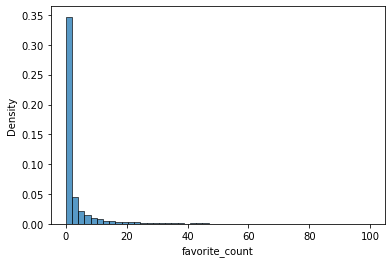

In [254]:
bins = np.linspace(0, 100, 50)

sns.histplot(df['favorite_count'], bins=bins, stat='density')
plt.show()

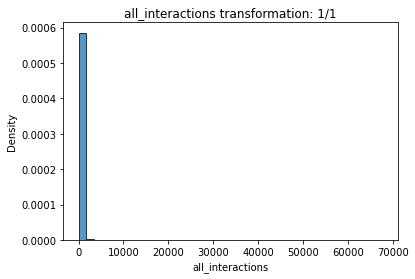

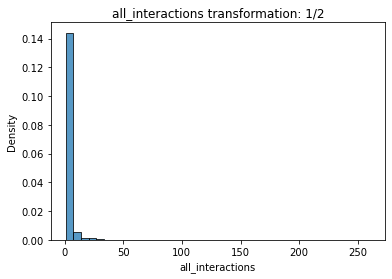

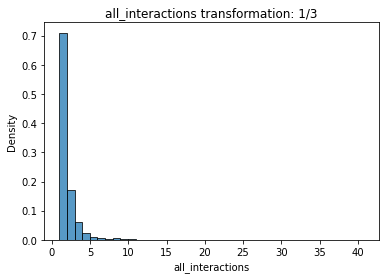

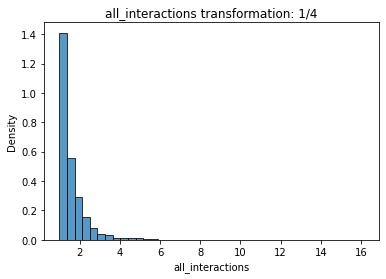

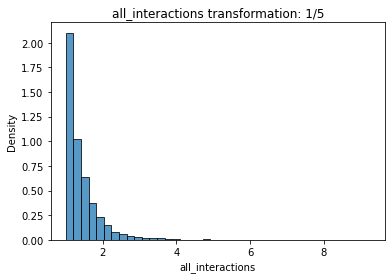

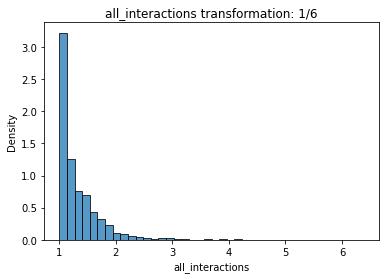

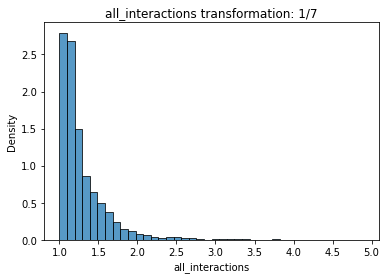

In [286]:
bins = np.linspace(0, 100, 50)
col = 'all_interactions'

for i in [1,2,3,4,5,6,7]:
    sns.histplot(df[df[col] > 0][col]**(1/i), bins = 40, stat='density')
#     sns.histplot(df[col]**(1/i), bins = bins, stat='density')
#     plt.hist((tdf[col])**(1/i), bins=40, normalize =True)
    plt.title('{} transformation: 1/{}'.format(col, i))
    plt.show()

In [ ]:
np.log10

In [282]:
np.log10(df[col]+1)

tid                  uid                
1333476068192366593  2152363202             1.342423
1364161232270487553  1331332400836726785    0.000000
1364161201291153414  150301804              0.000000
1364161184505737217  1317091162159747075    0.000000
1363439109948149760  1353391442408792066    1.431364
                                              ...   
1363947236128866322  983308145412931585     0.000000
1363947304705753090  802952556737691652     0.000000
1363947807921561600  290165045              0.301030
1363949275005263879  1680848514             0.602060
1363949692288004103  308788980              0.301030
Name: all_interactions, Length: 7662, dtype: float64

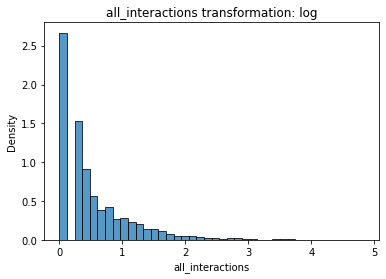

In [298]:
# bins = np.linspace(0, 100, 50)
col = 'all_interactions'

sns.histplot(np.log10(df[col]+1), bins = 40, stat='density')

plt.title('{} transformation: log'.format(col, i))
plt.show()

In [260]:
df.columns

Index(['quote_count', 'reply_count', 'retweet_count', 'favorite_count',
       'user_followers_count', 'user_verified', 'full_text', 'media_count',
       'media_types'],
      dtype='object')

trying to use the sum of all interactions instead of just favorites to get more non-zero values

In [263]:
df['all_interactions'] = df.apply(lambda x: sum([x['quote_count'], x['reply_count'], x['retweet_count'], x['favorite_count']]), axis=1)

In [264]:
df.head()

,,quote_count,reply_count,retweet_count,favorite_count,user_followers_count,user_verified,full_text,media_count,media_types,all_interactions
tid,uid,,,,,,,,,,
1333476068192366593,2152363202,0,2,3,16,6070,False,"Teen pregnancy is high, HIV infection rate is growing fastest among teens, and teens are experim...",0,none,21
1364161232270487553,1331332400836726785,0,0,0,0,62,False,Even though it was a charity. Stevens thought that speaking to DHSS rather than those suffering...,0,none,0
1364161201291153414,150301804,0,0,0,0,1044,False,SCORA\nStanding Committee on Sexual &amp; Reproductive Health and Rights including HIV&amp;AIDS\...,0,none,0
1364161184505737217,1317091162159747075,0,0,0,0,15,False,"many females are HIV+, we wish you well, blessings, we can't heal you totally, but providing rel...",0,none,0
1363439109948149760,1353391442408792066,0,0,2,24,184,False,@TheRustler83 Yep. Imagine if the government were demanding HIV tests weekly in every high school.,0,none,26


In [266]:
tdf.columns

Index(['tid', 'full_text', 'clean', 'hashtags', 'hashtags_count', 'mentions',
       'mentions_count', 'full_word_count', 'hashtags_ratio', 'mentions_ratio',
       'clean_no_@#'],
      dtype='object')

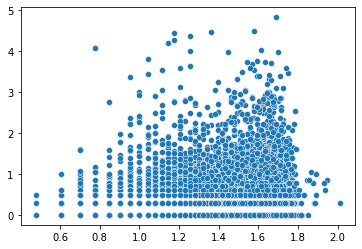

In [289]:
sns.scatterplot(x=np.log10(tdf['full_word_count'].values+1), y=np.log10(df['all_interactions'].values+1))
plt.show()

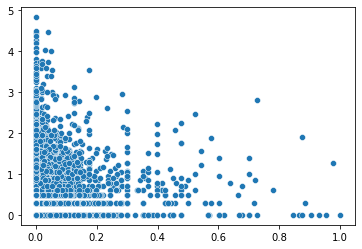

In [287]:
sns.scatterplot(x=np.log10(tdf['hashtags_ratio'].values+1), y=np.log10(df['all_interactions'].values+1))
plt.show()

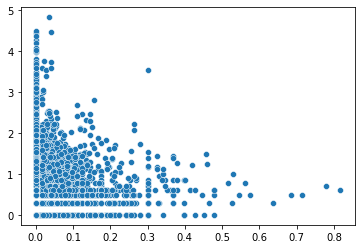

In [288]:
sns.scatterplot(x=np.log10(tdf['mentions_ratio'].values+1), y=np.log10(df['all_interactions'].values+1))
plt.show()

#### count vectorize all words (not stopwords, hashtags, or mentions)

In [168]:
cv = CountVectorizer()

In [177]:
X = cv.fit_transform(tdf['clean_no_@#'])

In [178]:
X.shape

(7662, 21131)

In [181]:
X_df = pd.DataFrame(X.toarray())
X_df.columns = cv.get_feature_names()
X_df.index = tdf.tid

In [182]:
X_df.head()

,000,0008,008world,00s,010,0121,01482,0151,01sbuh,02,...,อนค,ትሐ,养皋ｄ,ｐｒ,𝐐𝐔𝐄𝐄𝐍ᵇᵍº,𝑱𝒐𝒌𝒆𝒔,𝗡𝗢𝗪,𝗥𝗘𝗚𝗜𝗦𝗧𝗘𝗥,𝘽𝙍𝙀𝘼𝙆𝙄𝙉𝙂,𝙊𝙏𝘾
tid,,,,,,,,,,,,,,,,,,,,,
1333476068192366593,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1364161232270487553,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1364161201291153414,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1364161184505737217,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1363439109948149760,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### extract keywords

In [290]:
from gensim.summarization import keywords

In [293]:
tdf['keywords'] = tdf['clean_no_@#'].apply(lambda x: keywords(x).split('\n'))

In [294]:
tdf.head()

,tid,full_text,clean,hashtags,hashtags_count,mentions,mentions_count,full_word_count,hashtags_ratio,mentions_ratio,clean_no_@#,keywords
0,1333476068192366593,"Teen pregnancy is high, HIV infection rate is growing fastest among teens, and teens are experim...","[teen, pregnancy, high, hiv, infection, rate, growing, fastest, among, teen, teen, experimenting...",[],0,[],0,22,0.000,0.000,teen pregnancy high hiv infection rate growing fastest among teen teen experimenting sex need srh,[infection]
1,1364161232270487553,Even though it was a charity. Stevens thought that speaking to DHSS rather than those suffering...,"[even, though, charity, stevens, thought, speaking, dhss, rather, suffering, 1980, 1990, hiv, ha...","[hiv, haemophilia]",2,[bloodinquiry],1,25,0.167,0.083,even though charity stevens thought speaking dhss rather suffering 1980 1990 httpstcohzrl1mm0rx,[]
2,1364161201291153414,SCORA\nStanding Committee on Sexual &amp; Reproductive Health and Rights including HIV&amp;AIDS\...,"[scora, standing, committee, sexual, reproductive, health, right, including, hivampaids, cimsa, ...",[],0,[],0,15,0.000,0.000,scora standing committee sexual reproductive health right including hivampaids cimsa empowering ...,"[health, standing]"
3,1364161184505737217,"many females are HIV+, we wish you well, blessings, we can't heal you totally, but providing rel...","[many, female, hiv, wish, well, blessing, cant, heal, totally, providing, relief, medicine, salv...",[],0,[],0,33,0.000,0.000,many female hiv wish well blessing cant heal totally providing relief medicine salve specialty m...,"[female, providing, provider]"
4,1363439109948149760,@TheRustler83 Yep. Imagine if the government were demanding HIV tests weekly in every high school.,"[therustler83, yep, imagine, government, demanding, hiv, test, weekly, every, high, school]",[],0,[therustler83],1,15,0.000,0.100,yep imagine government demanding hiv test weekly every high school,[]


count vectorize just the nltk keywords

In [322]:
X_keywords = cv.fit_transform(tdf['keywords'].apply(lambda x: ' '.join(x)))

In [323]:
X_keywords.shape

(7662, 3770)

In [324]:
X_keywords_df = pd.DataFrame(X_keywords.toarray())
X_keywords_df.columns = cv.get_feature_names()
X_keywords_df.index = tdf.tid
X_keywords_df.head()

,abajo,abd,ability,able,aboot,aboriginal,abortion,absence,absolute,abstinence,...,zeal,zeitgeist,zika,zimbabwe,zimbabwean,zip,ยจำเป,𝗡𝗢𝗪,𝗥𝗘𝗚𝗜𝗦𝗧𝗘𝗥,𝘽𝙍𝙀𝘼𝙆𝙄𝙉𝙂
tid,,,,,,,,,,,,,,,,,,,,,
1333476068192366593,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1364161232270487553,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1364161201291153414,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1364161184505737217,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1363439109948149760,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### parts of speech

In [310]:
from collections import Counter

In [314]:
Counter([p[1] for p in nltk.pos_tag((tdf.iloc[0]['clean_no_@#']).split(' '))])

Counter({'JJ': 5, 'NN': 6, 'VBG': 2, 'JJS': 1, 'IN': 1})

In [316]:
pos_dict = {}
for row in tdf.index:
    counts = Counter([p[1] for p in nltk.pos_tag((tdf.at[row, 'clean_no_@#']).split(' '))])
    ind = tdf.at[row, 'tid']
    pos_dict[ind] = counts

In [318]:
pos_df = pd.DataFrame(pos_dict).T
pos_df.fillna(0, inplace=True)
pos_df = pos_df.astype(int)
pos_df.head()

,JJ,NN,VBG,JJS,IN,RB,NNS,VBD,CD,DT,...,WRB,WP$,TO,NNP,WP,PRP$,$,RP,POS,SYM
1333476068192366593,5,6,2,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1364161232270487553,0,3,2,0,1,2,1,1,2,0,...,0,0,0,0,0,0,0,0,0,0
1364161201291153414,3,6,4,0,0,1,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1364161184505737217,6,12,2,0,0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1363439109948149760,3,4,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn import StandardScalar
#use this on tone assessment?

In [ ]:
from skelearn.pipeline import make_pipeline